# Домашнее задание 2. Классификация, детекция.

Сделал **Пешков Максим**

группа **ИАД-4**

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

## Основные ссылки:

 Часть 1) https://github.com/hse-ds/iad-deep-learning/blob/master/sem05/sem05_solution.ipynb

Часть 2)
https://github.com/hse-ds/iad-deep-learning/blob/master/sem07/sem07_solve.ipynb

https://www.kaggle.com/yerramvarun/fine-tuning-faster-rcnn-using-pytorch


## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
!wget https://getfile.dokpub.com/yandex/get/https://yadi.sk/d/BNR41Vu3y0c7qA && unzip -q BNR41Vu3y0c7qA

--2020-11-25 11:10:26--  https://getfile.dokpub.com/yandex/get/https://yadi.sk/d/BNR41Vu3y0c7qA
Resolving getfile.dokpub.com (getfile.dokpub.com)... 78.46.92.107
Connecting to getfile.dokpub.com (getfile.dokpub.com)|78.46.92.107|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2020-11-25 11:10:26 ERROR 404: Not Found.



In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, Normalize, ToTensor, Compose

import glob

### Датасеты, даталоадеры, аугментация

In [ ]:
#выкачаем датасеты и сразу применим аугментацию из библиотеки torchvision.transforms
#аугментация как с семинара: изменение размера, нормирование
train_dataset = ImageFolder("./dataset/dataset/train", transform=Compose([Resize((224, 224)), ToTensor(), Normalize((0.5, 0.5, 0.5), (1, 1, 1)), ]))
val_dataset = ImageFolder("./dataset/dataset/val", transform=Compose([Resize((224, 224)), ToTensor(), Normalize((0.5, 0.5, 0.5), (1, 1, 1)), ]))

In [ ]:
#сделаем даталоадеры
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=True)

In [ ]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


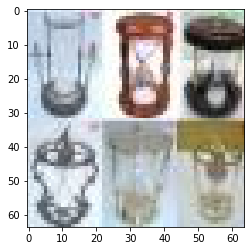

In [ ]:
#посмотрим на картинку в датасете
file = np.random.choice(glob.glob("./dataset/dataset/train/*/*.jpg"))
plt.imshow(plt.imread(file))

### Функции для обучения и предикта

In [ ]:
import tqdm
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model = model.to(device).train()
    all_losses = np.array([]) #все лоссы
    total_predictions = np.array([]) #все предсказания по объектам
    total_labels = np.array([]) #все истинные лейблы
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        predicted = model(images) #делаем предсказание
        loss = criterion(predicted, labels) #считаем лосс
        loss.backward() #обновляем веса
        optimizer.step() #шаг оптимайзера
        optimizer.zero_grad() #обнуляем градиенты
        total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy()) #добавляем предсказания
        total_labels = np.append(total_labels, labels.cpu().detach().numpy()) #добавляем лейблы
        all_losses = np.append(all_losses, loss.detach().item()) #добавляем лоссы

    accuracy_train = accuracy_score(total_labels, total_predictions) #считаем accuracy на трейне на одной эпохе по объектам
    print(f"Accuracy_epoch_train: {round(accuracy_train * 100, 4)} ") #печатаем accuracy

    return all_losses # возвращаем список лоссов

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model = model.eval()
    model.to(device)
    predicted_classes = np.array([]) # все предсказания на валидации
    true_classes = np.array([]) #все правильные лейблы на валидации
    losses = np.array([]) #все лоссы на валидации
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        predicted = model(images) #предсказание
        loss = criterion(predicted, labels) #лосс
        predicted_classes = np.append(predicted_classes, predicted.argmax(1).cpu().detach().numpy()) #добавляем в список предсказаний
        true_classes = np.append(true_classes, labels.cpu().detach().numpy()) #добавляем в список правильных лейблов
        losses = np.append(losses, loss.item()) #добавляем в список лоссов

    accuracy_val = accuracy_score(true_classes, predicted_classes) #считаем accuracy на валидации
    print(f"Accuracy_epoch_val: {round(accuracy_val * 100, 4)} ") #выводим accuracy на валидации
    return losses, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    from tqdm import tqdm
    model.to(device)
    LOSS_train = [] #все лоссы на трейне
    LOSS_val = [] #все лоссы на валидации
    for epoch in tqdm(range(n_epochs)):
        # Train step
        train_loss =  train_one_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            criterion=criterion
        )

        LOSS_train.extend(train_loss) #для каждой эпохи все лоссы train добавляем в список лоссов 

        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            val_loss,_,_ = predict(
                model=model,
                val_dataloader=val_dataloader,
                criterion=criterion
            )
        LOSS_val.extend(val_loss) #для каждой эпохи все лоссы валидации добавляем в список лоссов 
    #нарисуем графички лоссов
    fig, axs = plt.subplots(2, figsize = (10,12))
    n_train = np.arange(1, len(LOSS_train)+ 1)
    n_val = np.arange(1, len(LOSS_val)+ 1)

    axs[0].plot(n_train, LOSS_train)
    axs[0].set_title('Train Loss')
    axs[0].set_ylabel('Loss')
    axs[1].plot(n_val, LOSS_val)
    axs[1].set_title('Validation Loss')
    axs[1].set_xlabel('iterations')
    axs[1].set_ylabel('Loss')

### Задаем модель, оптимайзер, criterion

После тщетных попыток подобрать какую-то линейную модель с хорошим качеством, было видно, что максимальный accuracy был в районе 35, чего недостаточно, поэтому решил взять как на семинаре  - предобученный резнет и обучать последний линейный слой, ссылка на который есть вверху.

Более того, полученная модель позволяет решить сразу бонусную часть :)

Finetuning очень мощная штука!

In [ ]:
#Возьмем предобученный resnet18, будем обучать только последний линейный слой
from torchvision.models import resnet18

model = resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 200)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
#оптимайзер - АДАМ, criterion - CrossEntropy
optimizer = torch.optim.Adam(model.fc.parameters(), 1e-4)
criterion = nn.CrossEntropyLoss()
n_epochs = 5 #столько эпох, так как потом модель начинает немного переобучаться (лосс стоит на месте)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
torch.cuda.is_available()

True

Простой тест на проверку правильности написанного кода

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

Accuracy_epoch_val: 0.56 
tests passed


### Обучение модели и графики

  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy_epoch_train: 19.885 
Validation Epoch: 0


 20%|██        | 1/5 [05:07<20:29, 307.47s/it]

Accuracy_epoch_val: 38.11 
Accuracy_epoch_train: 44.535 
Validation Epoch: 1


 40%|████      | 2/5 [10:12<15:20, 306.72s/it]

Accuracy_epoch_val: 48.55 
Accuracy_epoch_train: 51.223 
Validation Epoch: 2


 60%|██████    | 3/5 [15:16<10:11, 305.89s/it]

Accuracy_epoch_val: 52.0 
Accuracy_epoch_train: 54.14 
Validation Epoch: 3


 80%|████████  | 4/5 [20:19<05:05, 305.15s/it]

Accuracy_epoch_val: 53.89 
Accuracy_epoch_train: 55.917 
Validation Epoch: 4


100%|██████████| 5/5 [25:24<00:00, 304.94s/it]

Accuracy_epoch_val: 55.27 


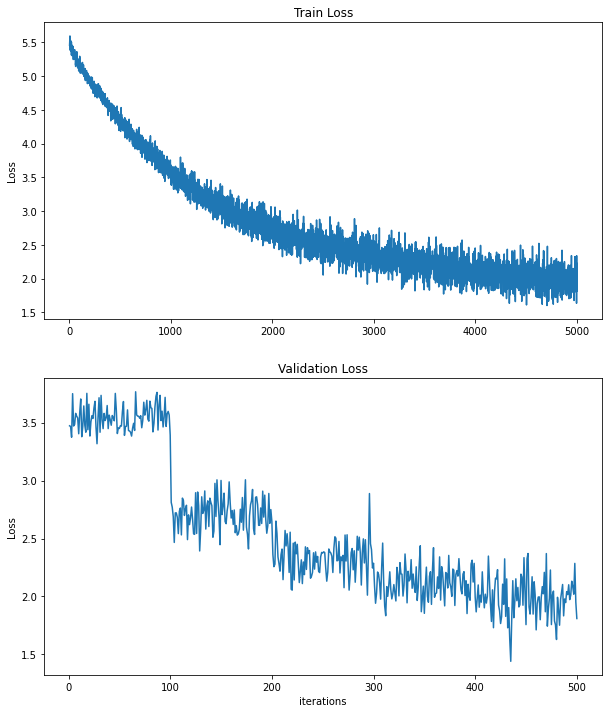

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler=None)

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print('Полученная accuracy составляет {}'.format(accuracy))
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))

Accuracy_epoch_val: 55.14 
Полученная accuracy составляет 0.5514
Оценка за это задание составит 5 баллов


### Отчет о проделанной работе

Итого, построенная модель показывает устойчивое обучение на трейне (лосс постепенно снижается), а также лосс на валидации снижается с каждой эпохой (каждые 100 итераций - 100 объектов в каждой эпохе, поэтому и такие резкие падения после каждого 100-го объекта). 

В данную работу не вошли мои эксперименты с разными другими моделями и оптимизаторами (пробовал модели из прошлой дз последней части), однако эти модели либо работали очень медленно, либо выдавали качество не больше 35% (возможно, я что-то не так делал, но такие неудачные эксперименты были). Однако, было замечено, что аугментация немного улучшает качество, поэтому решил ее оставить, как и советовали выше. Таким образом, создание и обучение новой модели для данного большого датасета в условиях ограничения памяти и времени являются сложными задачами, хотя и могут выдавать хорошее качество. Отсюда и пришла идея использовать уже предобученную модель и обучать только один линейный слой.

Построенная модель основывается на предобученным resnet18, который решал более серьезную задачу классификации для 1000 классов, а в данном задании я только обучал линейную модель на последнем слое, поэтому и полученное качество достаточно высокое (Finetuning лучший!)

## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [ ]:
! wget https://getfile.dokpub.com/yandex/get/https://yadi.sk/d/UPwQB7OZrB48qQ && unzip -q UPwQB7OZrB48qQ

--2020-11-20 12:14:33--  https://getfile.dokpub.com/yandex/get/https://yadi.sk/d/UPwQB7OZrB48qQ
Resolving getfile.dokpub.com (getfile.dokpub.com)... 78.46.92.107
Connecting to getfile.dokpub.com (getfile.dokpub.com)|78.46.92.107|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://downloader.disk.yandex.ru/disk/563d1c883677fa319461855e61ad301159592b4a9ea98b71bee36fa3d79f42c9/5fb7d21b/_YfpybMoWZm47imviby-3T3_P-JmBOk_RsfF-4bIvGOZYs-MElyFZHK9g3qV9TPfb6BX2FY5KQyjMDM5DD9_ng%3D%3D?uid=0&filename=archive.zip&disposition=attachment&hash=lOccmpIYRG/u%2BW1C9jHdqvsadVYmohN46j6tEz%2BQYeOfzEG3Cp1dQ4npcVmx8LuFq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=365556915&fsize=29737028&hid=d79a0119efd953a38f900e15ed7b0a40&media_type=compressed&tknv=v2 [following]
--2020-11-20 12:14:34--  https://downloader.disk.yandex.ru/disk/563d1c883677fa319461855e61ad301159592b4a9ea98b71bee36fa3d79f42c9/5fb7d21b/_YfpybMoWZm47imviby-3T3_P-Jm

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
# we will need this library to process the labeling
! pip install xmltodict

In [ ]:
import xmltodict, json

In [ ]:
torch.random.initial_seed()  
torch.cuda.manual_seed_all(8)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Класс датасета

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
# add any imports you need

class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

### Аугментация

In [ ]:
import albumentations as A
import cv2
from albumentations.pytorch.transforms import ToTensor

In [ ]:
def get_transform(train):
    #для трейна сделаем немного сложнее
    if train:
        return A.Compose([
                            A.RandomBrightnessContrast(p=0.2), #подкрасим
                            A.HorizontalFlip(0.5), #повернем
                            ToTensor() 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}) #pascal_voc - возращаем координаты коробки
    else:
        return A.Compose([
                            A.HorizontalFlip(0.5), #повернем
                            ToTensor()
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

### Техническая работа с семинаров

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

### Функции обучения и предикта

In [ ]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()
    n = 0
    global_loss = 0 #будем считать лосс
    for images, targets in train_dataloader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets) #предсказание
        losses = sum(loss for loss in dict_loss.values()) #суммируем лосс по картинкам

        optimizer.zero_grad() #обнуляем градиенты
        losses.backward() #обновляем лоссы
        optimizer.step() #шаг оптимизатора

        n += 1
        global_loss += float(losses.cpu().detach().numpy()) #добавляем в лоссы один лосс за шаг

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2))) #выводим средний лосс

    return global_loss


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        model.eval()
        a = evaluate(model, val_dataloader, device=device)
        print("AUC ON TEST: {}".format(round(float(a), 4)))
        model.train()
        train_one_epoch(model, train_dataloader, optimizer, device=device)

### Модель

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [ ]:
#взяли модель с семинара, ссылка вверху
def get_detection_model(num_classes=3):
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### Датасеты и даталоадеры

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch)) #полезная функция, чтобы возращать tuple

In [ ]:
torch.random.initial_seed()  
torch.cuda.manual_seed_all(8) #fix seed

#датасеты с аугментацией
dataset_train = FruitDataset('./train_zip/train/', transform=get_transform(train=True)) 
dataset_val = FruitDataset('./test_zip/test/', transform=get_transform(train=False))

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)

dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)

### Обучение модели

In [ ]:
n_epochs = 5
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = get_detection_model(4)
model.to(device)

#оптимайзер взяли SGD with momentum
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

train(model, dataloader_train, dataloader_val, optimizer, device, n_epochs)

AUC ON TEST: 0.0003
Loss value after 10 batches is 0.67
Loss value after 20 batches is 0.56
Loss value after 30 batches is 0.49
Loss value after 40 batches is 0.45
Loss value after 50 batches is 0.42
Loss value after 60 batches is 0.39
Loss value after 70 batches is 0.38
Loss value after 80 batches is 0.35
Loss value after 90 batches is 0.35
Loss value after 100 batches is 0.34
Loss value after 110 batches is 0.33
Loss value after 120 batches is 0.32
AUC ON TEST: 0.8152
Loss value after 10 batches is 0.22
Loss value after 20 batches is 0.2
Loss value after 30 batches is 0.2
Loss value after 40 batches is 0.19
Loss value after 50 batches is 0.2
Loss value after 60 batches is 0.21
Loss value after 70 batches is 0.21
Loss value after 80 batches is 0.2
Loss value after 90 batches is 0.19
Loss value after 100 batches is 0.2
Loss value after 110 batches is 0.19
Loss value after 120 batches is 0.19
AUC ON TEST: 0.9033
Loss value after 10 batches is 0.17
Loss value after 20 batches is 0.15
Los

### Итоговое качество модели

In [ ]:
auc = evaluate(model, dataloader_val, device)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc / 0.91)))

Оценка за это задание составит 4 баллов


### Нарисуем предсказанные боксы для картинок из тестового датасета

In [ ]:
image, labels = next(iter(dataset_val))
pred = model(image.unsqueeze(0).to(device))[0]

In [ ]:
#вытащим первые две картино4ки
i = 0
imagess = []
labelss = []
preds = []
for image, labels in dataset_val:
  imagess.append(image)
  labelss.append(labels)
  preds.append(model(image.unsqueeze(0).to(device))[0])
  i += 1
  if i >= 2:
    break

In [ ]:
image1 = imagess[0]
labels1 = labelss[0]
pred1 = preds[0]
image2 = imagess[1]
labels2 = labelss[1]
pred2 = preds[1]

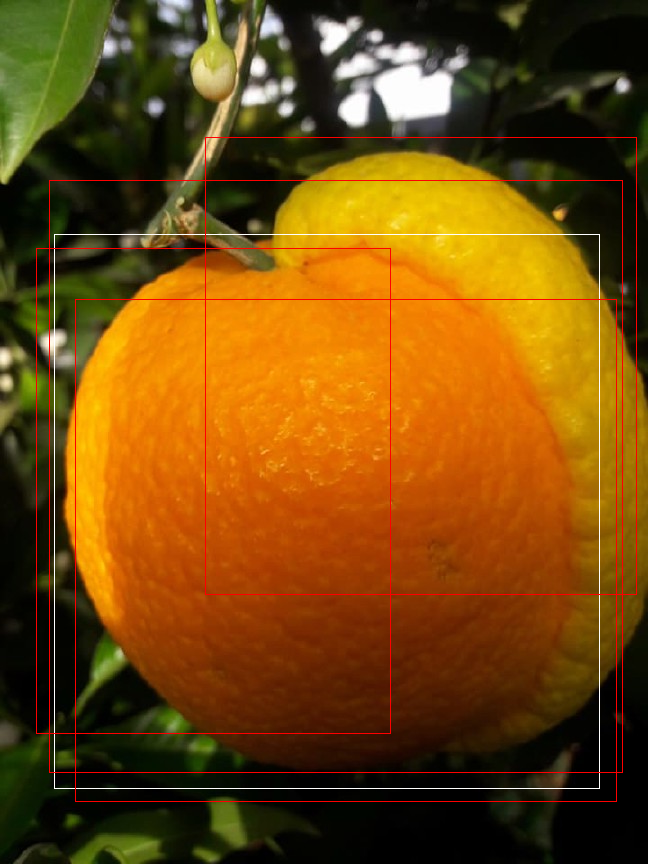

In [ ]:
from PIL import ImageDraw


image = torchvision.transforms.ToPILImage()(image1)
draw = ImageDraw.Draw(image)
for box in labels1['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred1['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

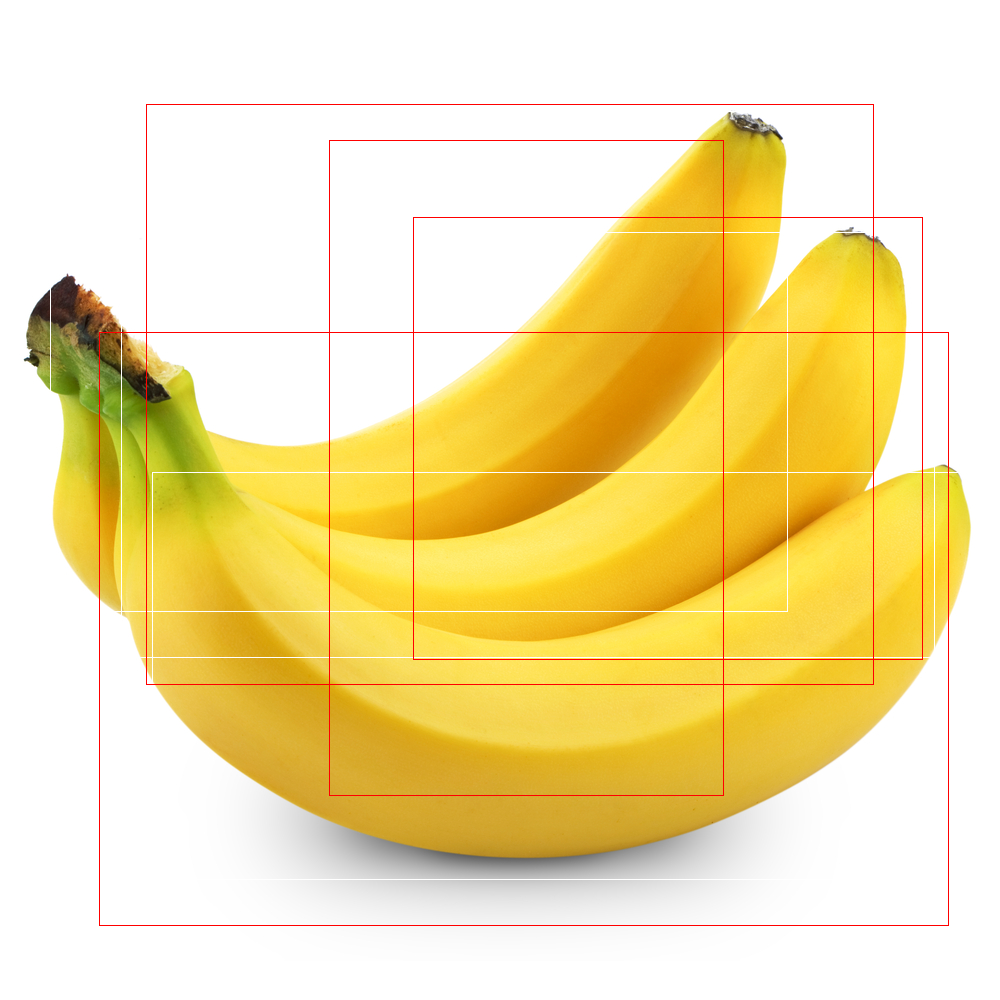

In [ ]:
image = torchvision.transforms.ToPILImage()(image2)
draw = ImageDraw.Draw(image)
for box in labels2['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred2['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

### Вывод о проделанной работе

Построенная модель детекции объектов Faster R-CNN показывает отличные показатели метрики IoU (более 90%), что свидетельствует об ее высоком качестве и применимости. Примеры качества видны выше на двух нарисованных картинках.

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь accuracy не менее 0.52. Напишите отчёт о проделанных экспериментах.

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы преодолели качество 0.52 и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

### Смотри в части 1

Использованная модель Fine Tuning в классификации **выше в части 1**, показало качество более 0.52, а точнее 0.55.

А именно был использован предобученный resnet18, но обучался только последний линейный слой, а также был использован оптимайзер Adam.

Такой метод построения модели показал хорошее качество на таком большом датасете и с большим количеством классов, так как уже предобученная модель способна угадывать паттерны на картинках, а значит все веса в модели позволяют это делать, а нам нужно только обучить один слой для корректировки на выбранный датасет.

Таким образом, метод Fine Tuning является очень полезным и мощным инструментом в задаче классификации объектов.

## Бонус (0 баллов).

__Задание 1__. Скиньте ниже смешную картинку, желательно про машинное обучение. На картинке не должно быть никаких упоминаний лектора, семинаристов и ассистентов этого курса.

__Задание 2__. Расскажите, как вам задание? Что понравилось, что не понравилось, что можно улучшить? Мы примем во внимание любой фидбек.

### Задание 1

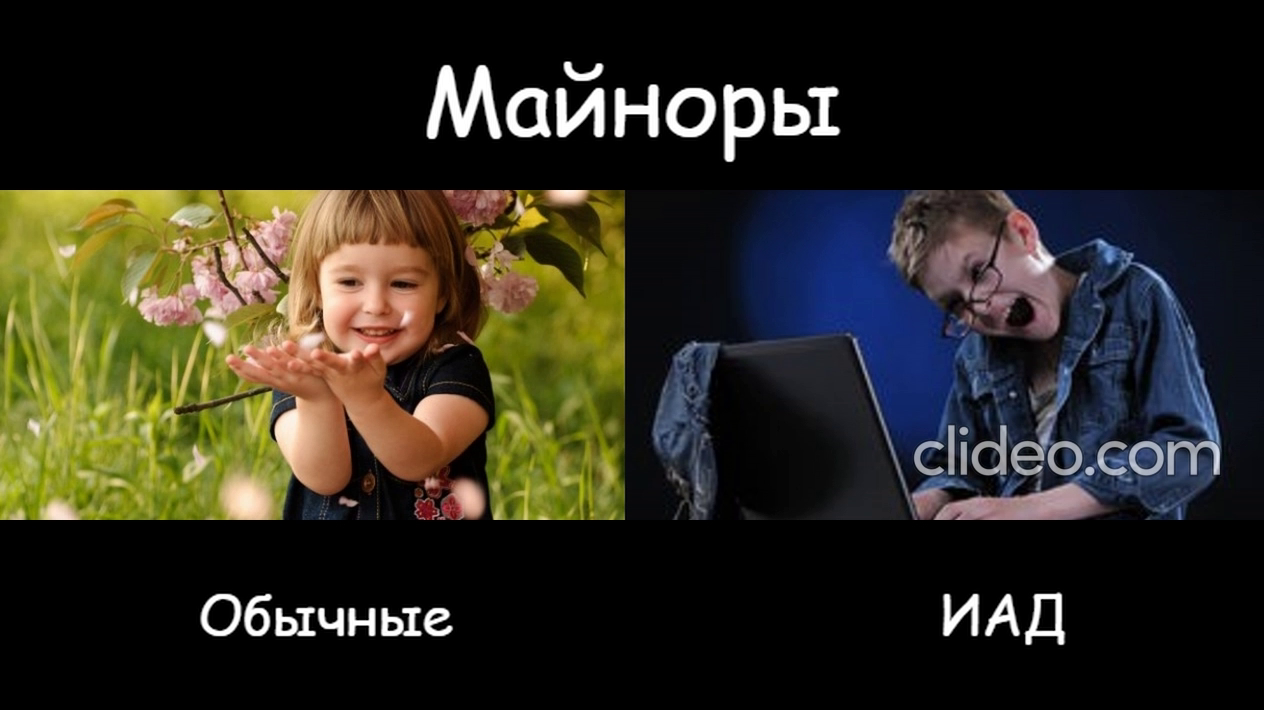